In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('processed.csv')
df.head()

,Unnamed: 0,difficulty,size,gas_limit,transaction_count,gas,past_min,past_mean,past_max,block_min
0,0,0.497304,1.525696,1.376636,0.768851,-0.306444,-0.471469,-0.552406,-0.503274,1.200000e+10
1,1,-0.175685,-0.151892,0.634122,-0.146996,0.373021,0.021040,0.091190,0.868203,6.000000e+09
2,2,0.074976,-1.414733,-0.108392,-0.544231,-0.382288,-0.202041,-0.555886,-0.473770,4.000000e+09
3,3,0.730501,0.085234,0.634122,-0.334579,-0.348186,0.036881,-0.276384,-0.418639,4.500000e+09
4,4,1.549208,0.792288,0.634122,0.934365,-0.309031,-0.300726,-0.273407,-0.412249,1.000000e+10


In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

## Train-Test split

In [4]:
from sklearn.model_selection import train_test_split
x = df.drop(['block_min'], axis=1)
y = df['block_min']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

## Gridsearch to tune parameters

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor(objective ='reg:squarederror')
no_of_estimators = [10, 30, 60, 100]
maximumdepth = [5, 10, 15, 20, 25]
parameters = {'n_estimators': no_of_estimators ,'max_depth': maximumdepth}
model = GridSearchCV(estimator=xgb, param_grid=parameters, cv=3, scoring='r2', return_train_score=True, verbose=1)
model.fit(x_train[:100000], y_train[:100000])

Model with best parameters :
 {'max_depth': 20, 'n_estimators': 100}


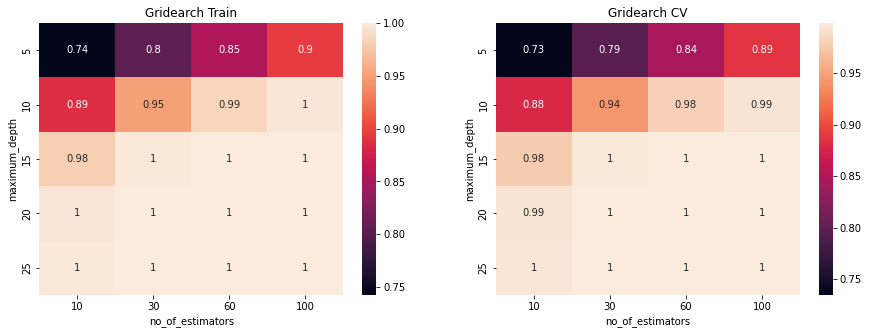

In [10]:
print("Model with best parameters :\n", model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(len(maximumdepth), len(no_of_estimators))
cv_auc = model.cv_results_['mean_test_score'].reshape(len(maximumdepth), len(no_of_estimators))

f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
    title = train_auc if i == 0 else cv_auc
    sns.heatmap(title, xticklabels=no_of_estimators, yticklabels=maximumdepth, annot=True, ax=axes[i])
    axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
    axes[i].set_xlabel("no_of_estimators")
    axes[i].set_ylabel("maximum_depth")

## Training the model

In [8]:
xgb_r = XGBRegressor(objective ='reg:squarederror', **model.best_params_)
xgb_r.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [12]:
y_pred = xgb_r.predict(x_test)

In [19]:
y_p_tr = xgb_r.predict(x_train)

In [17]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score, r2_score
from math import sqrt

def calculateMetric(y_pred,y_test):
    print("MAE=",mean_absolute_error(y_test,y_pred))
    print("RMSE=",sqrt(mean_squared_error(y_test,y_pred)))
    print("R2 Score", r2_score(y_test,y_pred))

In [18]:
calculateMetric(y_pred, y_test)

MAE= 651670.1749795419
RMSE= 44699988.05220334
R2 Score 0.9999633106845792


In [20]:
calculateMetric(y_p_tr, y_train)

MAE= 29836.3234181727
RMSE= 104531.07309060234
R2 Score 0.9999999998144701
